In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import open3d as o3d

In [46]:
def read_calibration_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    calib = {}
    for line in lines:
        key, value = line.split(': ', 1)
        if 'calib_time' in key:
            continue
        calib[key.strip()] = np.array([float(x) for x in value.strip().split()])
    
    return calib

def read_kitti_bin_file(bin_file_path):
    # Read the binary file
    point_cloud = np.fromfile(bin_file_path, dtype=np.float32)
    
    # Reshape the data into Nx4 array (x, y, z, intensity)
    point_cloud = point_cloud.reshape(-1, 4)
    
    return point_cloud

In [47]:
# read camera lidar extrinsic calibration file
filename = 'calib_velo_to_cam.txt'
velo2cam = read_calibration_file(filename)

Rcl = velo2cam['R'].reshape(3, 3)
tcl = velo2cam['T'].reshape(3, 1)

print("Rotation matrix R:")
print(Rcl)
print("\nTranslation vector T:")
print(tcl)

Rotation matrix R:
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01]
 [ 9.998621e-01  7.523790e-03  1.480755e-02]]

Translation vector T:
[[-0.00406977]
 [-0.07631618]
 [-0.2717806 ]]


In [48]:
# read camera camera calibration file
# suppose we want to use camera 02 since it is an RGB camera

filename = 'calib_cam_to_cam.txt'
cam2cam = read_calibration_file(filename)

R02 = cam2cam['R_rect_02'].reshape(3, 3)
P02 = cam2cam['P_rect_02'].reshape(3, 4)
t02 = cam2cam['T_02'].reshape(3, 1)

print("\nRotation matrix R02:")
print(R02)
print("\nProjection matrix P02:")
print(P02)
print("\nTranslation vector T02:")
print(t02)


Rotation matrix R02:
[[ 9.998817e-01  1.511453e-02 -2.841595e-03]
 [-1.511724e-02  9.998853e-01 -9.338510e-04]
 [ 2.827154e-03  9.766976e-04  9.999955e-01]]

Projection matrix P02:
[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]

Translation vector T02:
[[0.05956621]
 [0.00029001]
 [0.00257721]]


In [49]:
# load point cloud data
bin_file_path = '0000000059.bin'
point_cloud = read_kitti_bin_file(bin_file_path)
point_cloud = point_cloud[point_cloud[:, 0] > 0]
print(point_cloud.shape)

(62896, 4)


(375, 1242, 3)


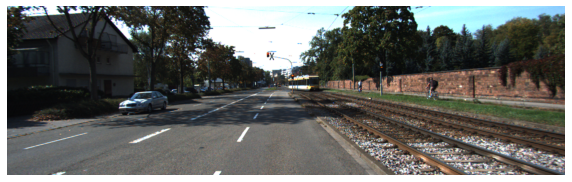

In [60]:
# load iamge data
img_file_path = '0000000059.png'
img = plt.imread(img_file_path)
print(img.shape)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [51]:
# structure the point cloud data
point_cloud = pd.DataFrame(point_cloud, columns=['x', 'y', 'z', 'intensity'])

# calculate the 3D points in camera 2 coordinate system
points_cam0 = (Rcl @ point_cloud[['x', 'y', 'z']].values.T + tcl)
points_cam2 = R02.T @ (points_cam0 - t02)

In [52]:
# add rgb color to the point cloud
colors = np.zeros((point_cloud.shape[0], 3))
init_colors = pd.DataFrame(colors, columns=['r', 'g', 'b'])
df = pd.concat([point_cloud, init_colors], axis=1)

In [53]:
# Project 3D points to 2D image coordinates
points_cam2_homogeneous = np.concatenate((points_cam2, np.ones((1, points_cam2.shape[1]))), axis=0)
points_img = P02 @ points_cam2_homogeneous

# Normalize the image coordinates
points_img_normalized = points_img / points_img[2]

# Convert the image coordinates to pixel indices
pixel_indices = points_img_normalized[:2].astype(int).T

valid_indices = (pixel_indices[:, 0] < img.shape[1]) & (pixel_indices[:, 1] < img.shape[0]) & \
                (pixel_indices[:, 0] >= 0) & (pixel_indices[:, 1] >= 0)

point_cloud.loc[valid_indices, ['r', 'g', 'b']] = \
    img[pixel_indices[valid_indices, 1], pixel_indices[valid_indices, 0]]

point_cloud = point_cloud[valid_indices]


In [54]:
# plot with image color
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[['x', 'y', 'z']].values)
pcd.colors = o3d.utility.Vector3dVector(point_cloud[['r', 'g', 'b']].values)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])

In [58]:
# plot with depth
depth = np.sqrt(point_cloud['x'].values ** 2 + point_cloud['y'].values ** 2)
point_cloud['depth'] = depth

depth_normalized = (depth - depth.min()) / (depth.max() - depth.min())
colors = plt.cm.viridis(depth_normalized)[:, :3]  # Using viridis colormap

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[['x', 'y', 'z']].values)
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd])